# ExprRules

This is the base package to support the generation and optimization of Julia expressions from a grammar.  The package contains many basic function for declaring and working with grammars and expression trees.

## Installation

    Pkg.add("ExprRules")

Once it's installed, start using the package by calling:

In [20]:
using ExprRules

## Usage

### Define a grammar

Each equality is a production rule specifying a possible substitution of the non-terminal symbol on the LHS by the expression on the RHS.  The RHS can be any Julia expression, such as a terminal or non-terminal symbol, or a function call.  The _() function is a special function where the argument is evaluated at the time of derivation tree's construction.  The pipe (|) syntax is a short-hand that allows the user to define multiple production rules on a single line.  The |() syntax is another similar short-hand that takes a collection as argument and creates a production rule for each element in the collection.

In [21]:
grammar = @grammar begin
    Real = x
    Real = Real * Real
    Real = f(Real)
    Real = _(Base.rand(1.0:5.0))
    Real = A | B | g(Real)
    Real = 1 | 2 | 3
    Real = |(4:6)
    Real = |([7,8,9])
end
grammar.rules

16-element Array{Any,1}:
  :x                      
  :(Real * Real)          
  :(f(Real))              
  :(_(Base.rand(1.0:5.0)))
  :A                      
  :B                      
  :(g(Real))              
 1                        
 2                        
 3                        
 4                        
 5                        
 6                        
 7                        
 8                        
 9                        

## Grammar helper functions

List non-terminals of the grammar:

In [22]:
nonterminals(grammar)

1-element Array{Symbol,1}:
 :Real

Get the return type of the first production rule:

In [23]:
return_type(grammar, 1)

:Real

Get the number of children of the second production rule:

In [24]:
nchildren(grammar, 2)

2

Get the child types of the second production rule:

In [25]:
child_types(grammar, 2)

2-element Array{Symbol,1}:
 :Real
 :Real

Get the maximum number of children (arity) of the grammar:

In [26]:
max_arity(grammar)

2

Determine if the third production rule is terminal:

In [27]:
isterminal(grammar, 3)

false

Determine if the fourth production rule is a special _() function:

In [28]:
iseval(grammar, 4)

true

## Expression trees

Define an expression tree:

In [29]:
rulenode = RuleNode(3, [RuleNode(6)])
display(rulenode, grammar)

Generate a random expression tree from the grammar:

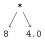

In [30]:
srand(100)
rulenode = rand(RuleNode, grammar, :Real, 10)
display(rulenode, grammar)

Evaluate the expression defined by the expression tree:

In [31]:
eval(rulenode, grammar)

32.0

Sample a random node in the tree:

In [32]:
srand(0)
sample(rulenode)

15,

Sample a random node of type :Real in the expression tree:

In [33]:
srand(3)
sample(rulenode, :Real, grammar)

2{15,4}

Sample a random node in the tree and store the location in a NodeLoc object:

In [34]:
srand(1)
loc = sample(NodeLoc, rulenode)

ExprRules.NodeLoc(2{15,4}, 1)

Retrieve the node pointed to by the NodeLoc object:

In [35]:
get(rulenode, loc)

15,

Replace the subtree pointed to by loc with a randomly generated subtree:

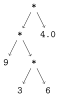

In [36]:
srand(28)
insert!(rulenode, loc, rand(RuleNode, grammar, :Real, 3))
display(rulenode, grammar)

## Expression Iterator

Iterate over all possible expressions of a grammar up to depth 2:

In [37]:
grammar = @grammar begin
    Real = Real + Real
    Real = 1 | 2
end
iter = ExpressionIterator(grammar, 2, :Real)
collect(iter)

6-element Array{ExprRules.RuleNode,1}:
 1{2,2}
 1{2,3}
 1{3,2}
 1{3,3}
 2,    
 3,    

Count the number of expressions of a grammar up to depth 2:

In [38]:
count_expressions(grammar, 2, :Real)

6